In [1]:
import sys

sys.path.append('./source/')

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import integrate, stats
import matplotlib.cm as cm
from numpy import fft
from scipy import interpolate as intp
import importlib


from source import plots
from source import prob_dists as pd
from utils import read_param_file, update_params

In [3]:
param_file = './source/n0.params'
params = read_param_file(param_file)
p = params
p

{'R_G': 220,
 'd_solar': 8.5,
 'psi': 40,
 'M_min': 0.1,
 'M_max': 10000000000.0,
 'fwimp': 1.78,
 'mean_params': {'a': 77.4, 'b': 0.87, 'c': -0.23},
 'nside': 128,
 'area_fermi': 2000.0,
 'n': 0,
 'log_flux_min': -16,
 'log_flux_max': -2,
 'N': 2200,
 'log_k_min': -2,
 'log_k_max': 10,
 'N_k': 250000,
 'psh_log_f_min': -7,
 'psh_log_f_max': -1.0,
 'N_psh': 1000,
 'omega_pixel': 6.391586616190171e-05,
 'exposure': 5570.423008216337,
 'iso_flux_bg': 0.0008615905978150363,
 'gal_flux_bg_file': './output/gal_flux_bg.npy',
 'bg': 1,
 'beg': 1,
 'beta': 1.9}

In [4]:
# p = update_params(param_file, p, 'exposure', 5 * 14000 / (4 * np.pi))

In [5]:
with np.load('./output/n0_pshfunc.npz') as f:
    psi = f['psi']
    fluxes = f['flux']
    psh2d = f['psh']

pshfunc2d = intp.interp2d(psi, fluxes, np.nan_to_num(psh2d), bounds_error=False, fill_value=0)
fluxes = fluxes[:-55]
np.log10(fluxes[-1])

-5.1044176706827304

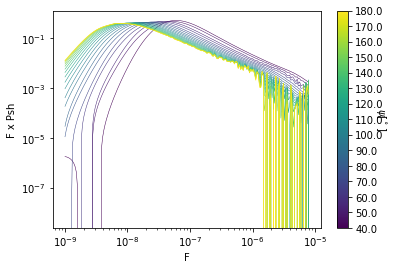

In [6]:
numnum = 20
psis = np.linspace(40, 180, num=numnum)
colors = cm.viridis(np.linspace(0, 1, num=numnum))

fig, ax = plt.subplots()

psh_vals_over_psi = []
fxs = fluxes
for psi, col in zip(psis, colors):
    ax.plot(fxs, fxs * pshfunc2d(psi, fxs).flatten(), label=rf"{psi}$^\circ$", color=col, lw=0.5)
#     print(np.trapz(fxs * pshfunc2d(psi, fxs).flatten(), fxs))
   
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('F')
ax.set_ylabel('F x Psh')
cbarlabs = np.arange(min(psis), max(psis)+1, step=10)
cbar = fig.colorbar(cm.ScalarMappable(cmap=cm.viridis), ticks=np.linspace(0, 1, num=len(cbarlabs)))
cbar.set_label(r'$\psi$[$^\circ$]', rotation=270)
cbar.ax.set_yticklabels(cbarlabs);

In [7]:
pshfunc2d(psis, fluxes).shape, psis.shape, fluxes.shape

((195, 20), (20,), (195,))

In [8]:
for psi in psis:
    minn = pshfunc2d(psi, fluxes).argmin()
    print(psi, pshfunc2d(psi, fluxes)[minn])

40.0 [-2699.89643964]
47.368421052631575 [-35752.7221056]
54.73684210526316 [-72120.96057235]
62.10526315789474 [-42769.78993768]
69.47368421052632 [-10183.96823925]
76.84210526315789 [46.17932766]
84.21052631578948 [27.72552995]
91.57894736842105 [4.90822673]
98.94736842105263 [-20.09082926]
106.3157894736842 [-40.3683338]
113.68421052631578 [-56.86859716]
121.05263157894737 [-59.70317436]
128.42105263157896 [-126.34164288]
135.78947368421052 [-220.08719323]
143.1578947368421 [-327.13135679]
150.5263157894737 [-428.74428862]
157.89473684210526 [-511.3479094]
165.26315789473682 [-604.58211028]
172.6315789473684 [-659.51584665]
180.0 [-714.44958301]


In [9]:
counts = np.arange(0, 20)
exposure = p['exposure']
psi = 40

In [10]:
from scipy.stats import poisson
print(poisson.pmf(counts[:, np.newaxis], exposure * fluxes).shape, pshfunc2d(40, fluxes).flatten().shape)

pcvals = np.trapz(pshfunc2d(psi, fluxes).flatten() * poisson.pmf(counts[:, np.newaxis], exposure * fluxes), fluxes, axis=-1)
# func = pshfunc2d(40, fluxes).flatten() * poisson.pmf(2, exposure * fluxes)
pcvals

(20, 195) (195,)


array([9.97656152e-01, 8.16827774e-04, 2.30843715e-06, 1.50725669e-08,
       1.04760322e-10, 6.66897270e-13, 3.80698815e-15, 1.95155507e-17,
       9.04092680e-20, 3.81234664e-22, 1.47331946e-24, 5.25091175e-27,
       1.73550696e-29, 5.34594451e-32, 1.54149994e-34, 4.17725143e-37,
       1.06756240e-39, 2.58121263e-42, 5.92134139e-45, 1.29212189e-47])

In [11]:
print(exposure*np.trapz(fluxes * pshfunc2d(40, fluxes).flatten(), fluxes))
pp = poisson.pmf(counts, exposure*np.trapz(fluxes * pshfunc2d(40, fluxes).flatten(), fluxes))

0.0008214902884996427


Text(0, 0.5, 'P(C) for 40 deg, n=0')

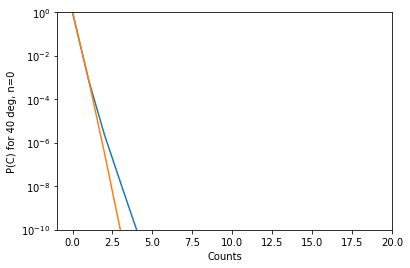

In [12]:
plt.plot(counts, pcvals)
plt.plot(counts, pp)
ax = plt.gca()

ax.set_yscale('log')
ax.set_ylim(top=1, bottom=1e-10)
ax.set_xlim(right=20)
ax.set_xlabel('Counts')
ax.set_ylabel('P(C) for 40 deg, n=0')

In [13]:
import healpy

In [14]:
nside = p['nside']
npix = healpy.nside2npix(nside)
pixel_counts = np.ones(npix) * healpy.pixelfunc.UNSEEN
print(npix)

196608


In [15]:
lon, lat = healpy.pix2ang(nside, range(npix), lonlat=True)
ang_dists = np.rad2deg(np.arccos(np.cos(np.deg2rad(lon)) * np.cos(np.deg2rad(lat))))
ang_dists, lon, lat

(array([89.74156502, 90.25843498, 90.25843498, ..., 90.25843498,
        90.25843498, 89.74156502]),
 array([ 45., 135., 225., ..., 135., 225., 315.]),
 array([ 89.6345165,  89.6345165,  89.6345165, ..., -89.6345165,
        -89.6345165, -89.6345165]))

In [16]:
lon, lat, max(ang_dists), min(ang_dists)

(array([ 45., 135., 225., ..., 135., 225., 315.]),
 array([ 89.6345165,  89.6345165,  89.6345165, ..., -89.6345165,
        -89.6345165, -89.6345165]),
 179.70158313251247,
 0.2984168674875423)

In [17]:
print(healpy.nside2pixarea(128, degrees=True))

0.2098234113027917


In [18]:
psis = np.linspace(40, 180, num=50)
pc_psi = np.array([np.trapz(pshfunc2d(abs(psi), fluxes).flatten() * poisson.pmf(counts[:, np.newaxis], exposure * fluxes), fluxes, axis=-1) for psi in psis])
pc_of_psi = intp.interp1d(psis, pc_psi, axis=0)

In [19]:
good_indices = (abs(lat) >= 40)

In [20]:
# subsample = ang_dists[good_indices]
# print(len(subsample))
# sub_counts = np.zeros(len(subsample))
# for i, psi in enumerate(subsample):
#     if i % 10000 == 0:
#         print(i, '/', len(subsample))
# #     print(psi)
#     pcvals = pc_of_psi(abs(psi))
#     sub_counts[i] = np.random.choice(np.arange(len(pcvals)), size=1, p=pcvals/np.sum(pcvals))
    
# pixel_counts[good_indices] = sub_counts
# pixel_counts_pc = pixel_counts[:]

In [21]:
np.sum(pixel_counts > 0)

0

In [22]:
# nreduce = 64
# healpy.mollview(healpy.pixelfunc.ud_grade(healpy.pixelfunc.ma(pixel_counts_pc), nreduce, pess=True, power=-2), cmap=cm.jet, title="Mollview P(C)")
# print(healpy.nside2pixarea(nreduce, degrees=True))
# np.mean(pixel_counts_pc[good_indices]), np.sum(pixel_counts_pc[good_indices])

In [23]:
# lsub = len(subsample)
# pixel_counts_poisson = np.ones(npix) * healpy.pixelfunc.UNSEEN
# sub_counts = np.zeros(lsub)
# for i, psi in enumerate(subsample):
#     if i % 100000 == 0:
#         print(i, '/', lsub)
# #     print(psi)
#     sub_counts[i] = stats.poisson.rvs(exposure*np.trapz(fluxes * pshfunc2d(psi, fluxes).flatten(), fluxes))
#     if sub_counts[i] > 5: 
#         print(sub_counts[i])
    
# pixel_counts_poisson[good_indices] = sub_counts


In [24]:
# healpy.mollview(healpy.pixelfunc.ud_grade(healpy.pixelfunc.ma(pixel_counts_poisson), nreduce, pess=True, power=-2), cmap=cm.jet, title="Poisson", max=14)
# np.mean(pixel_counts_poisson[good_indices]), np.sum(pixel_counts_poisson[good_indices])

In [26]:
importlib.reload(pd)
# with np.load('./output/n0_pshfunc_paper.npz') as f:
#     psi = f['psi']
#     fluxes = f['flux']
#     psh2d = f['psh']

# # restrict to valid range of flux calculation
# valid_lim = -129
# lower = 40
# fluxes = fluxes[lower:valid_lim]
# psh2d = psh2d[lower:valid_lim]

psh, pshfunc2d, fluxes, _ = pd.psh_s(ang_dists[good_indices], input_file='./output/n0_pshfunc_paper.npz', return_all=True)
# generate data with different fwimp

# p['fwimp'] *= 5
# f = p['fwimp']*50
f = 1
# fluxes *= f
# psh2d /= f

# get psh data as function of psi and flux
counts = np.arange(0, 500)
# psh2d[psh2d < 0] = 0
# pshfunc2d = intp.interp2d(psi, fluxes, np.nan_to_num(psh2d), bounds_error=False, fill_value=0)

# make the simulated skymap
psis = np.linspace(40, 180, num=50)
pc_psi = np.array([integrate.simps(1/f * pshfunc2d(abs(psi), fluxes).flatten() * stats.poisson.pmf(counts[:, np.newaxis], p['exposure'] * f * fluxes), f * fluxes, axis=-1) for psi in psis])
pc_of_psi = intp.interp1d(psis, pc_psi, axis=0)

# backgrounds
gal_bg = np.load(p['gal_flux_bg_file'])[good_indices] * p['exposure']
iso_bg = p['iso_flux_bg'] * p['exposure']
bg_count = gal_bg + iso_bg
# add backgrounds
background = False
if background is False:
    bg_count = []

# subcounts, ang_dists, _ = pd.generate_skymap_sample_pc_2(p, pshfunc2d, fluxes, return_subcounts=True, save_output=True, with_bg=background)
# subcounts, ang_dists, _ = pd.generate_skymap_sample_pc(p, pc_of_psi, ang_dists[good_indices], good_indices, return_subcounts=True, save_output=True, bg_counts=[])
subcounts = pd.generate_skymap_sample_pc(p, pc_of_psi(ang_dists[good_indices]), ang_dists[good_indices], good_indices, return_subcounts=True, save_output=True, bg_counts=bg_count)
print(subcounts)

# get psh for the angles we are considering 
psh = pshfunc2d(np.abs(ang_dists), fluxes)
psh /= integrate.simps(psh, fluxes, axis=0)
print(ang_dists.shape, psh.shape, fluxes.shape)

<N_true> is 0.1759195193999414
saved in ./output/n0_skymap_48973.npy
[1. 0. 0. ... 2. 0. 0.]
(196608,) (100, 196608) (100,)


<ipython-input-26-32ca4619be48>:48: RuntimeWarning: invalid value encountered in true_divide
  psh /= integrate.simps(psh, fluxes, axis=0)


In [26]:
# pc_psi

In [27]:
importlib.reload(pd)
import time
start_time = time.time()
num_search = 100
fwimp_search = (np.log10(f)-2, np.log10(f)+2, num_search)

# backgrounds
gal_bg = np.load(p['gal_flux_bg_file'])[good_indices] * p['exposure']
iso_bg = p['iso_flux_bg'] * p['exposure']
bg_count = gal_bg + iso_bg
# bg_count = np.array([0])

# use different subcoutns?
# subcounts = np.load('./output/n0_skymap_23454.npy')[good_indices]

counts = np.arange(0, max(subcounts)+1)

# chop up psh to get avoid mem error
# fluxes = fluxes[::3]
# psh = psh[::3]

S, fwimps = pd.likelihood(p, psh, subcounts.astype(np.int16), fluxes, counts, fwimp_limits=fwimp_search, bg_count=bg_count, verbose=True)

print('time per eval', (time.time() - start_time)/num_search)

TypeError: likelihood() got an unexpected keyword argument 'fwimp_limits'

In [ ]:
fig, axs = plt.subplots()
axs.plot(fwimps, np.exp(-0.5*(S - S.min())), color='xkcd:tangerine', label='P(C)')
# axs.plot(fwimps, S)
axs.set_xlabel(r'f$_{WIMP}$', fontsize=20)
axs.set_xscale('log')
# axs.set_ylabel(r'$\mathcal{S}-\mathcal{S}_{min}$', fontsize=20)
axs.set_ylabel(r'$\mathcal{L}$', fontsize=20)
# axs.set_ylim(bottom=0, top=1)
print(p['fwimp'], 'fwimp:', fwimps[S.argmin()], '\t S:', S.min())
# print('max L:', np.exp(-0.5*S.min()))

In [ ]:
S

In [ ]:
subcounts, np.mean(subcounts), np.std(subcounts)

In [ ]:
subcounts, np.mean(subcounts), np.std(subcounts)

In [ ]:
importlib.reload(pd)
Spoi, fwimpspoi = pd.poisson_likelihood(p, psh, subcounts.astype(np.int16), fluxes, counts, fwimp_limits=fwimp_search)

In [ ]:
S-S.min()

In [ ]:
axs.plot(fwimpspoi, (-(Spoi-Spoi.min())), color='xkcd:wine', label='Poisson')
axs.legend()
axs.set_yscale('linear')
print('P(C) min of -2 ln L:', S.min())
print('Poisson min of -2 ln L:', Spoi.min())
fig

In [ ]:
print(fwimps[Spoi.argmin()], Spoi.min())
print(np.log10(np.e)*1500)

In [ ]:
from astropy.io import fits
bg = fits.open('output/background.fits')

In [ ]:
bg[0].header

In [ ]:
a = np.reshape(np.arange(9), (3, 3))
print(a)
a[np.array([[1, 0], [1, 2] , [2, 1]])]

In [ ]:
import scipy.stats as st

class my_pdf(st.rv_continuous):
    def _pdf(self, x):
        return custom_pdf(x)
    
    def _cdf(self, x):
        return custom_cdf(x)
    
    def _ppf(self, x):
        return custom_ppf(x)

In [ ]:
psi = 50
custom_pdf = lambda x: pshfunc2d(psi, x).flatten()

norm = np.trapz(pshfunc2d(psi, fluxes).flatten(), fluxes)
discrete_cdf = integrate.cumtrapz(pshfunc2d(psi, fluxes).flatten(), fluxes, initial=0)
custom_cdf = intp.interp1d(fluxes, discrete_cdf, fill_value=0, bounds_error=False)

custom_ppf = intp.interp1d(discrete_cdf, fluxes, fill_value=0, bounds_error=False)

func50 = my_pdf(a=fluxes.min(), b=fluxes.max(), name='my_pdf')

In [ ]:
# pcvals = np.trapz(pshfunc2d(psi, fluxes).flatten() * poisson.pmf(counts[:, np.newaxis], exposure * fluxes), fluxes, axis=-1)

def pc(psi, counts_max=15):
    counts = np.arange(0, counts_max + 1)
    
    pcvals = np.trapz(pshfunc2d(psi, fluxes).flatten() * poisson.pmf(counts[:, np.newaxis], exposure * fluxes), fluxes, axis=-1)
    custom_pdf = intp.interp1d(counts, pcvals, fill_value=0, bounds_error=False)
    
    discrete_cdf = integrate.cumtrapz(pcvals, counts, initial=0)
    custom_cdf = intp.interp1d(counts, discrete_cdf, fill_value=0, bounds_error=False)

    custom_ppf = intp.interp1d(discrete_cdf, counts, fill_value=0, bounds_error=False)
    
    return my_pdf(a=fluxes.min(), b=fluxes.max(), name='my_pdf')

In [ ]:
pc(50).rvs(size=10)

In [ ]:
psi = 40
pcvals = np.trapz(pshfunc2d(psi, fluxes).flatten() * poisson.pmf(counts[:, np.newaxis], exposure * fluxes), fluxes, axis=-1)
pp = poisson.pmf(counts, exposure*fluxes[np.argmax(pshfunc2d(psi, fluxes))])

print(np.sum(pcvals/np.sum(pcvals)))
plt.plot(counts, pcvals)
plt.plot(counts, pp)
plt.hist(np.random.choice(np.arange(len(pcvals)), size=100000, p=pcvals/np.sum(pcvals)))

ax = plt.gca()
ax.set_yscale('log')
# ax.set_ylim(top=1, bottom=1e-20)
ax.set_xlabel('Counts')
# ax.set_xscale('log')
ax.set_ylabel('P(C) for 40 deg, n=0')

In [ ]:
fig, ax = plt.subplots()
bins = np.logspace(np.log10(fluxes.min()), np.log10(fluxes.max()), num=50)
ax.hist(func50.rvs(size=100000), bins=bins)
ax.plot(fxs, fxs * pshfunc2d(psi, fxs).flatten(), label=rf"{psi}$^\circ$")
ax.set_xscale('log')
ax.set_yscale('log')

In [ ]:
for i, latt in enumerate(lat):
    if latt < 40:
        pixel_counts[i] = 0
    else:
        